
# 📘 **Sweet Lift Taxi — Predicting Taxi Orders**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

## 📚 **Index**

- [🚀 **1. Project Overview**](#1-project-overview)  
- [🗂️ **2. Data Preparation**](#2-data-preparation)  
- [🧠 **3. Analysis**](#3-analysis)  
- [📊 **4. Model Training and Evaluation**](#4-model-training-and-evaluation)  
    - [🏆 **4.1. Best ARIMA-like Model**](#41-best-arima-like-model)  
    - [🧩 **4.2. Autoregressive Model**](#42-autoregressive-model)  
    - [⚙️ **4.3. Moving Average Model**](#43-moving-average-model)  
    - [📈 **4.4. Linear Regression Model**](#44-linear-regression-model)  
    - [🌳 **4.5. Random Forest Model**](#45-random-forest-model)  
- [🧾 **5. Conclusions**](#5-conclusions)

</div>

# 🚀 **1. Project Overview**
<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

<b>Sweet Lift Taxi</b> company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. 

#### 🎯 **Project Objective**

Sweet Lift Taxi is interested in building a model to predict the amount of taxi orders for the next hour. <br>

#### ✅ **Success Criteria:** 

Achieve a competitive RMSE that should not be more than 48.

</div>

In [37]:
# 🚀 Import all required libraries

# Core
import sys, platform
import time
import pandas as pd
import numpy as np
import sklearn

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Models
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import mean_squared_error


# Environment check

print("OS:", platform.platform())
print('Python:', sys.version)
print('Pandas:', pd.__version__)
print('NumPy:', np.__version__)
print('Seaborn:', sns.__version__)
print('sklearn:',sklearn.__version__)

OS: Linux-6.1.155-176.282.amzn2023.x86_64-x86_64-with-glibc2.36
Python: 3.9.23 (main, Jul 22 2025, 01:40:31) 
[GCC 12.2.0]
Pandas: 1.2.4
NumPy: 1.21.2
Seaborn: 0.11.1
sklearn: 0.24.1


# **📊 2. Data Preparation**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">
➡️ In this section, we will load, inspect, and preprocess the dataset to ensure it is ready for modeling. <br>
The steps include:<br>
    
- Loading the data and reviewing its structure.
- Convert data to a convenient format. 
- Set `datetime` as index.
- Verify time intervals. 
- Resample it by one hour.


</div>

In [38]:
# 📥 Load the data set 
df = pd.read_csv('/datasets/taxi.csv')

In [39]:
# Display general information
print('--- Dataset Info ---')
print(df.info())
print('\n--- Preview (first 5 rows) ---')
display(df.head())

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None

--- Preview (first 5 rows) ---


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">
🔎 The dataset contains two columns:<br>

`datetime` — represents the date and time along the time axis. In this dataset, the interval between records is 10 minutes. *(Type: object)*  
`num_orders` — the number of taxi orders recorded at each time point.*(Type: float)* 

The time series preview shows consistent spacing between entries (10 minutes)
</div>


In [40]:
#Convert data to a convenient format. 
df['datetime'] = pd.to_datetime(df['datetime'])

In [41]:
# Calculate the difference between consecutive rows
df_diff = df['datetime'].diff()

# Display the unique time differences
df_diff.value_counts()

0 days 00:10:00    26495
Name: datetime, dtype: int64

In [42]:
# Set 'datetime' as index
df = df.set_index('datetime')

In [43]:
# Check if the dates and times are in chronological order.
df.index.is_monotonic_increasing # Should return True

True

In [44]:
# Resample by one hour
df_1h= df.resample('1H').sum()

# **📉 3. Data Analysis**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px;">
➡️ In this section, we will analyze and preprocess the dataset to ensure it is ready for modeling.  
The steps include:

- Exploring distribution. 
- Exploring trends, seasonality and residuals.
- Splitting the data into training and test sets to enable modeling and fair performance comparison later.

🧠 **Goal:** produce a clean, well-structured dataset that supports both interpretability and efficient training across models.
</div>

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [46]:
# Display the time range
print('Time range:')
print(f"From {df_1h.index.min()} to {df_1h.index.max()}")

# Descriptive statistics for 'num_orders'
print('\nDescriptive statistics for num_orders:')
display(df_1h['num_orders'].describe())

Time range:
From 2018-03-01 00:00:00 to 2018-08-31 23:00:00

Descriptive statistics for num_orders:


count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

<AxesSubplot:xlabel='datetime'>

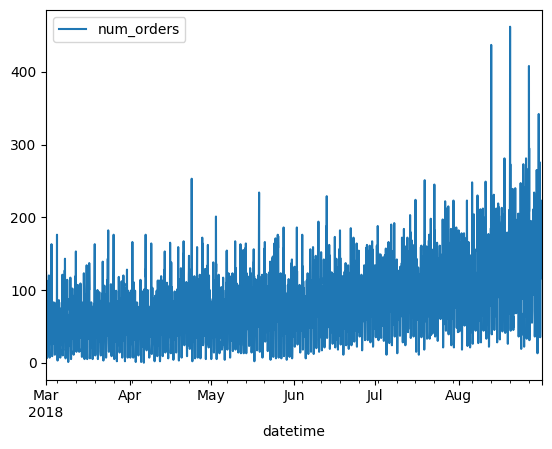

In [47]:
# Explore distribution
df_1h.plot()


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 The line plot shows how the **number of taxi orders** changes over time. Overall, demand appears to increase gradually from March to August, with noticeable spikes toward the end of the series, possibly reflecting periods of higher activity or special events

</div>


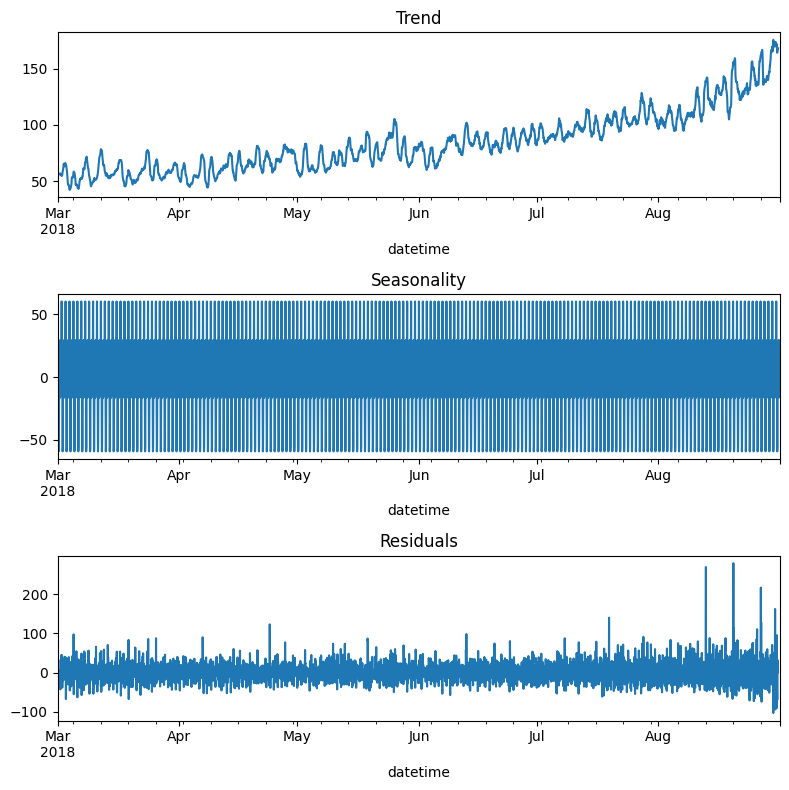

In [48]:


decomposed = seasonal_decompose(df_1h)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')


plt.tight_layout()

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 **Time Series Decomposition Summary**

- **Trend:** The overall number of taxi orders is increasing over time — demand seems to grow steadily from March to August.  
- **Seasonality:** The demand rises and falls in a consistent rhythm. 
- **Residuals:** Most fluctuations are similar, but a few spikes stand out — maybe due to special events or unusual days.

In short, the data shows both a clear upward trend and a strong seasonality.
</div>

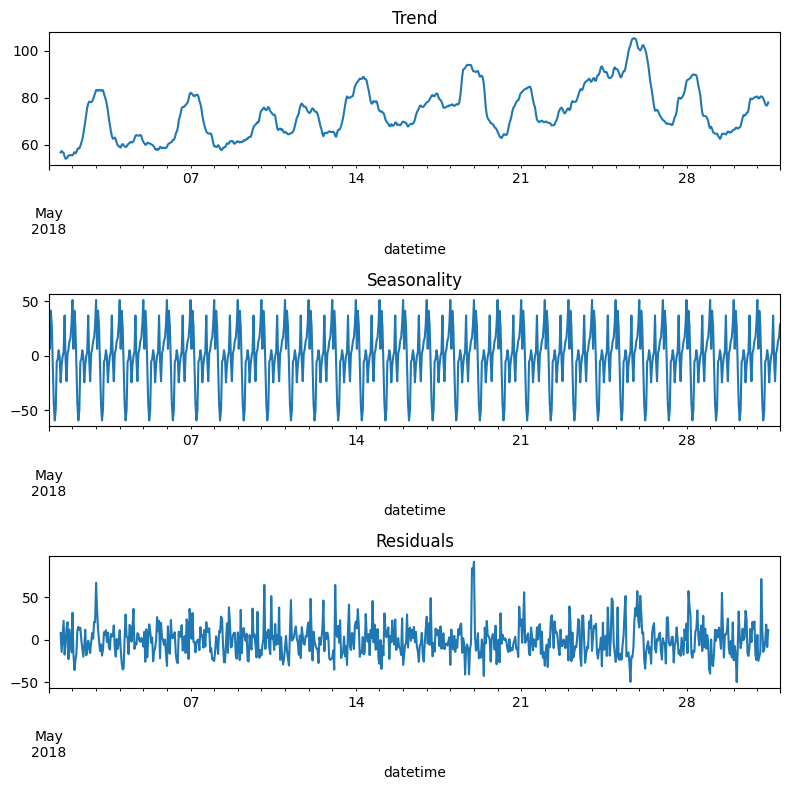

In [49]:
# Check trends, seasonality and residuales in an arbitrary month

df_may = df_1h ['2018-05-01-00:00:00':'2018-05-31-23:00:00']
decomposed = seasonal_decompose(df_may)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')


plt.tight_layout()

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 **Time Series Decomposition (One-Month Overview)**

- **Trend:** The general pattern moves up and down smoothly, showing cycles of higher and lower demand within the month. It doesn’t grow sharply, but small waves suggest short-term fluctuations in taxi usage.  
- **Seasonality:** The daily rhythm is very clear — demand rises and falls in a consistent pattern each day, repeating almost identically throughout the month.  
- **Residuals:** The random noise remains relatively stable, with a few noticeable peaks that might reflect unusual days or isolated spikes in demand.

Overall, this month’s data shows a pattern with strong daily seasonality and some short-term ups and downs in the trend.
</div>

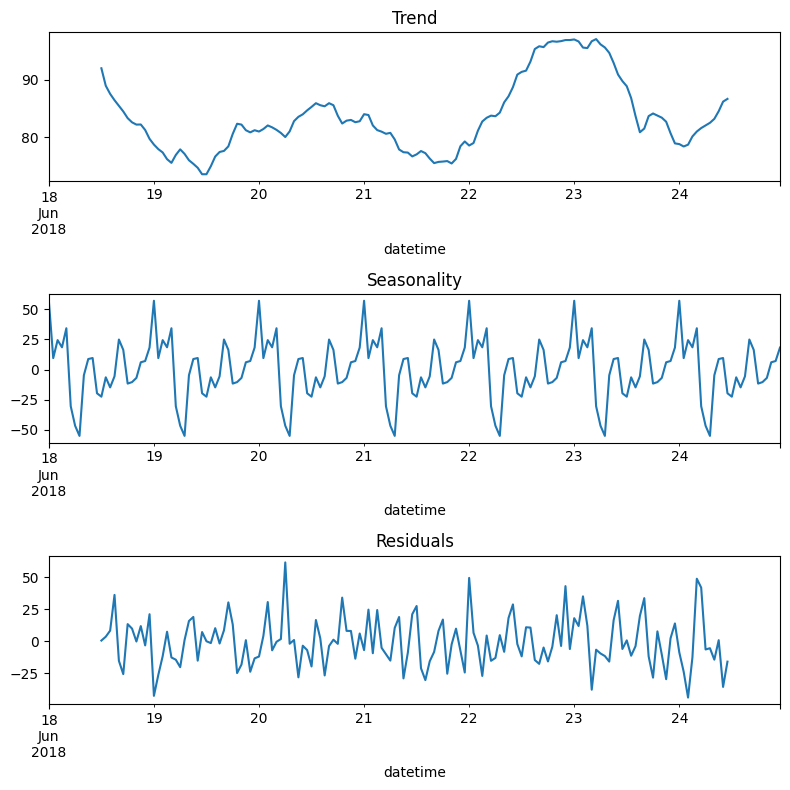

In [50]:
# Check trends, seasonality and residuales in an arbitrary week

df_2weeks = df_1h ['2018-06-18-00:00:00':'2018-06-24-23:00:00']
decomposed = seasonal_decompose(df_2weeks)
plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')


plt.tight_layout()

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 **Time Series Decomposition (Two Week)**

- **Trend:** The general level of taxi orders goes up and down smoothly during the week. There are small rises and drops, but no big long-term changes.  
- **Seasonality:** The daily pattern is clear now — demand repeats every day with regular peaks and lows, probably higher during busy hours and lower at night.  
- **Residuals:** The random noise is small and centered around zero, with just a few spikes that could be special days or events.

In short, this weekly view shows a clear daily rhythm and small variations from day to day.
</div>

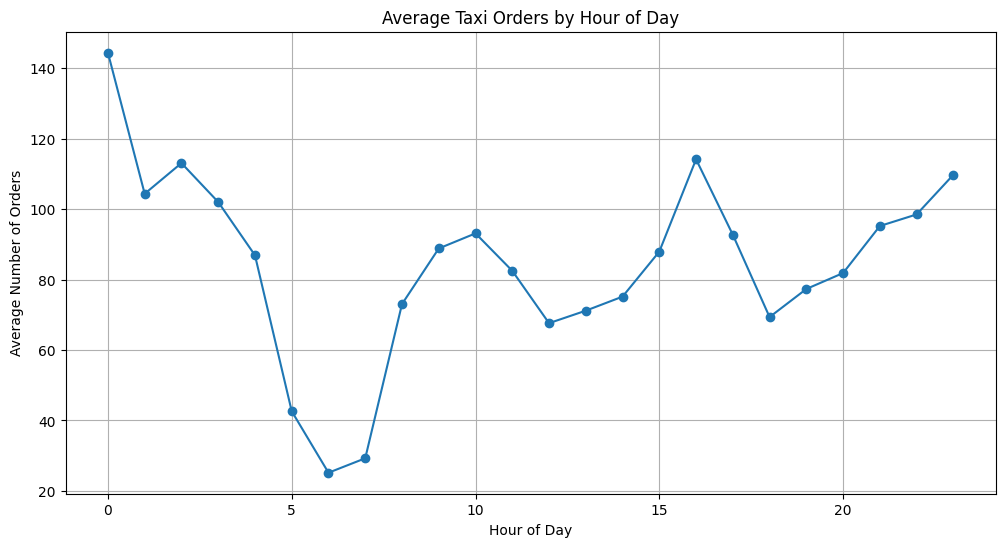

In [51]:
# Look at average orders by hour across all days
hourly_pattern = df_1h.groupby(df_1h.index.hour)['num_orders'].mean()
plt.figure(figsize=(12, 6))
plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o')
plt.title('Average Taxi Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Orders')
plt.grid(True)
plt.show()

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 This chart shows how the **average number of taxi orders changes during the day**.

- The demand is **highest just after midnight**, likely due to people returning home from late activities.  
- It then **drops sharply between 3:00 and 6:00 a.m.**, when most people are asleep.  
- After sunrise, there’s a **steady increase through the morning**, followed by a small dip around midday.  
- In the **afternoon and early evening**, demand rises again — probably linked to commuting hours.  
- Finally, orders remain moderately high until midnight.

Overall, the chart reveals a **strong daily pattern**: two clear peaks (midnight and late afternoon).
</div>

In [52]:
# Splitting the data into training and test sets (test sample should be 10% of the initial dataset)

from sklearn.model_selection import train_test_split
df_1h.sort_index(inplace=True)
train, test = train_test_split(df_1h, shuffle=False, test_size=0.1)

print('Train:')
print(train.index.min(), train.index.max())
print('\nTest:')
print(test.index.min(), test.index.max())

Train:
2018-03-01 00:00:00 2018-08-13 13:00:00

Test:
2018-08-13 14:00:00 2018-08-31 23:00:00



# 🧠 **4. Model Training and Evaluation**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

➡️ In this section:<br>
- We will train several models to **predict the number of taxi orders**.  
- We will assess each model’s performance using the **RMSE** metric on the test set.  
- The target goal is to achieve an RMSE **below 48**.

</div>

### **4.1 🏆 Best ARIMA-like Model with auto_arima**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

➡️ We first attempted to identify the best ARIMA-like model using **seasonality = 24** (hourly data → daily cycle). However, the environment did not support this configuration — the **kernel repeatedly crashed** during the model search.  

➡️ Next, we **reduced the seasonal search space** by setting tighter bounds for *p, d, q* and *P, D, Q*, and testing alternative configurations to lighten computation. Despite these adjustments, the **kernel still failed** with the same issue.  

➡️ As a fallback, we continued with a **non-seasonal ARIMA model** to ensure stability and establish a reliable baseline while the seasonal setup is being reviewed.

</div>

In [53]:
%%time

model = auto_arima(
    train['num_orders'],
    seasonal=False,
    scoring='mae',
    stepwise=True
)

CPU times: user 6.82 s, sys: 9.01 s, total: 15.8 s
Wall time: 7.92 s


In [54]:
# get info about the model
parameters = model.get_params()
for key, value in parameters.items():
    print(f"{key}: {value}")

maxiter: 50
method: lbfgs
order: (0, 1, 1)
out_of_sample_size: 0
scoring: mae
scoring_args: {}
seasonal_order: (0, 0, 0, 0)
start_params: None
suppress_warnings: True
trend: None
with_intercept: False


In [55]:
%%time 

# make predictions
predictions = model.predict(len(test))

CPU times: user 4.75 ms, sys: 27.6 ms, total: 32.3 ms
Wall time: 10.6 ms


In [56]:
# evaluate model
rsme_value = np.sqrt(mean_squared_error(test, predictions))

print(f'➡️ Model RSME: {rsme_value}')

➡️ Model RSME: 62.76809456268275


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 The non-seasonal ARIMA model achieved an RMSE of **62.77**, which indicates a moderate fit but still falls short of the performance goal (<48). 

</div>

### **🧩 4.2  Autoregressive Model**


In [57]:
%%time

import warnings
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

warnings.filterwarnings('ignore')

# find optimal number of lags
mod = ar_select_order(endog=train, maxlag=30)
ar_order = mod.ar_lags

# create AR model and fit it using the training set
ar_model = AutoReg(train, lags=ar_order, seasonal=True)
ar_model = ar_model.fit()



CPU times: user 207 ms, sys: 865 ms, total: 1.07 s
Wall time: 509 ms


In [58]:
%%time

from sklearn.metrics import mean_squared_error

# make predictions
start_value = len(train)
end_value = len(train) + len(test) - 1
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

# evaluate model
ar_rsme_value = np.sqrt(mean_squared_error(test, ar_pred)) 

print(f'➡️ AR model RSME: {ar_rsme_value}')

➡️ AR model RSME: 69.91861857569376
CPU times: user 18.6 ms, sys: 82.5 ms, total: 101 ms
Wall time: 86 ms


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 The Autoregressive (AR) model reached an RMSE of **69.92**, showing a weaker predictive performance compared to the non-seasonal ARIMA model. 

</div>

### **4.3 ⚙️ Moving Average Model**



In [59]:
%%time

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from matplotlib import pyplot as plt


# find optimal order for MA model
res = arma_order_select_ic(y=train, max_ar=0, max_ma=10)
ma_order = res.bic_min_order[1]

# create and fit MA model
ma_model = ARIMA(train, order=(0, 0, ma_order))
ma_model = ma_model.fit()

print("Output of the arma_order_select_ic() function is:", res.bic_min_order)

Output of the arma_order_select_ic() function is: (0, 8)
CPU times: user 34.8 s, sys: 1min 38s, total: 2min 13s
Wall time: 1min 7s


In [60]:
%%time

# make predictions
start_value = len(train)
end_value = len(train) + len(test) - 1
ma_pred = ma_model.predict(start=start_value, end=end_value, dynamic=False)

# calculate RSME of predictions
ma_rsme_value = np.sqrt(mean_squared_error(test, ma_pred)) 

print(f'➡️⚙️ Moving Average model RSME: {ma_rsme_value}')

➡️⚙️ Moving Average model RSME: 84.676491139629
CPU times: user 4.49 ms, sys: 31 ms, total: 35.5 ms
Wall time: 82.9 ms


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 The Moving Average (MA) model obtained an RMSE of **84.68**, indicating the least accurate performance among the models tested so far. 

</div>


### **4.4 📈 Linear Regression Model**


In [61]:

%%time

from sklearn.linear_model import LinearRegression

# Create time-based features

def make_features(df_1h, max_lag, rolling_mean_size):
    df_1h['month'] = df_1h.index.month
    df_1h['day'] = df_1h.index.day
    df_1h['dayofweek'] = df_1h.index.dayofweek
    df_1h['is_weekend'] = (df_1h['dayofweek'] >= 5).astype(int)
    df_1h['is_week_day'] = (df_1h['dayofweek'] < 5).astype(int)
    df_1h['hour'] = df_1h.index.hour
    df_1h['is_peak_midnight'] = df_1h['hour'].isin([23, 0, 1]).astype(int)
    df_1h['is_peak_evening'] = df_1h['hour'].isin([16, 17, 18]).astype(int)
    df_1h['is_low_early'] = df_1h['hour'].isin([3, 4, 5]).astype(int)

    # Sine/cosine encoding for cyclical hour pattern
    df_1h['hour_sin'] = np.sin(2 * np.pi * df_1h['hour'] / 24)
    df_1h['hour_cos'] = np.cos(2 * np.pi * df_1h['hour'] / 24)
    
    # Day of week sine/cosine (weekly pattern)
    df_1h['dow_sin'] = np.sin(2 * np.pi * df_1h['dayofweek'] / 7)
    df_1h['dow_cos'] = np.cos(2 * np.pi * df_1h['dayofweek'] / 7)


    for lag in range(1, max_lag + 1):
        df_1h['lag_{}'.format(lag)] = df_1h['num_orders'].shift(lag)

    df_1h['rolling_mean'] = (
        df_1h['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

make_features(df_1h, 6, 10)

train, test = train_test_split(df_1h, shuffle=False, test_size=0.1)
train = train.dropna()

test_features = test.drop('num_orders', axis=1)
train_features = train.drop('num_orders', axis=1)
test_target = test['num_orders']
train_target = train['num_orders']

model = LinearRegression()
model.fit(train_features, train_target)




CPU times: user 20.3 ms, sys: 0 ns, total: 20.3 ms
Wall time: 17.5 ms


LinearRegression()

In [62]:
%%time


train_predictions = model.predict(train_features)
test_predictions = model.predict(test_features)
rsme_train = np.sqrt(mean_squared_error(train_target, train_predictions))
rsme_test = np.sqrt(mean_squared_error(test_target, test_predictions))

print(f'➡️📈 Linear Regression model RSME for train set:', rsme_train)
print(f'➡️📈 Linear Regression model RSME for test set:', rsme_test)

➡️📈 Linear Regression model RSME for train set: 28.15777814022234
➡️📈 Linear Regression model RSME for test set: 52.2770880929271
CPU times: user 0 ns, sys: 39.6 ms, total: 39.6 ms
Wall time: 5.91 ms


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 The Linear Regression model achieved an RMSE of **52.28** on the test set, showing a clear improvement over the ARIMA, AR, and MA models. 

</div>

### **4.4 🌳 Random Forest Regressor Model**


In [63]:
%%time

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=12345)

# Try different hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Grid search for best parameters
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(train_features, train_target)

# Best model
best_rf = grid_search.best_estimator_

CPU times: user 2min 27s, sys: 0 ns, total: 2min 27s
Wall time: 2min 27s


In [64]:
%%time
# Predict on the test set and evaluate RMSE
test_pred = best_rf.predict(test_features)
rmse_RandomForest = np.sqrt(mean_squared_error(test_target, test_pred))
print(f"➡️🌳 Random Forest RMSE: {rmse_RandomForest:.5f}")



➡️🌳 Random Forest RMSE: 44.69298
CPU times: user 12.9 ms, sys: 0 ns, total: 12.9 ms
Wall time: 12.1 ms


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 The Random Forest model achieved an RMSE of **44.69**, successfully surpassing the performance goal (<48). This result indicates a strong predictive capability, suggesting that the ensemble approach effectively captures non-linear relationships and complex patterns in the data with efficient computation time.

</div>

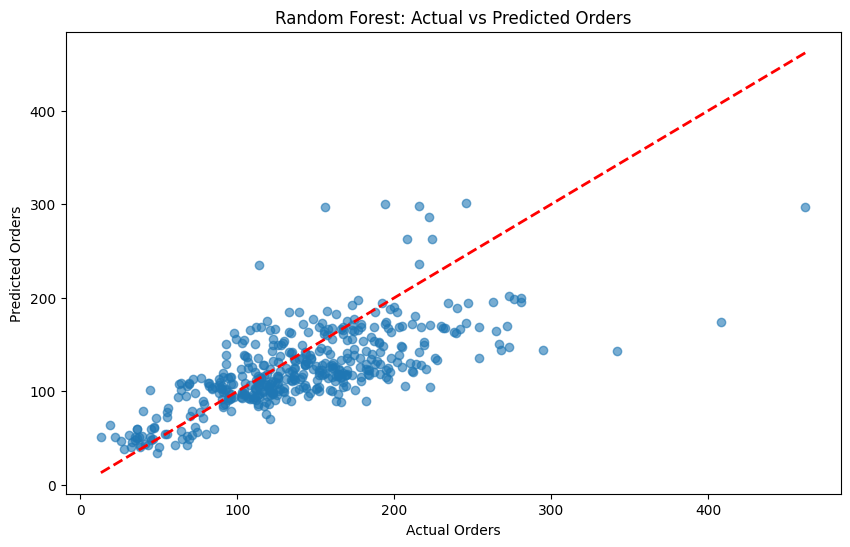

In [65]:
# Actual vs predictes values plot

plt.figure(figsize=(10, 6))
plt.scatter(test_target, test_pred, alpha=0.6)
plt.plot([test_target.min(), test_target.max()], [test_target.min(), test_target.max()], 'r--', lw=2)
plt.xlabel('Actual Orders')
plt.ylabel('Predicted Orders')
plt.title('Random Forest: Actual vs Predicted Orders')
plt.show()


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 The scatter plot comparing **actual vs. predicted orders** shows that the Random Forest model performs quite well. Most points are close to the red diagonal line, meaning the predictions are generally accurate. There are a few scattered outliers, especially at higher order values, but overall the model captures the main pattern of the data effectively.

</div>

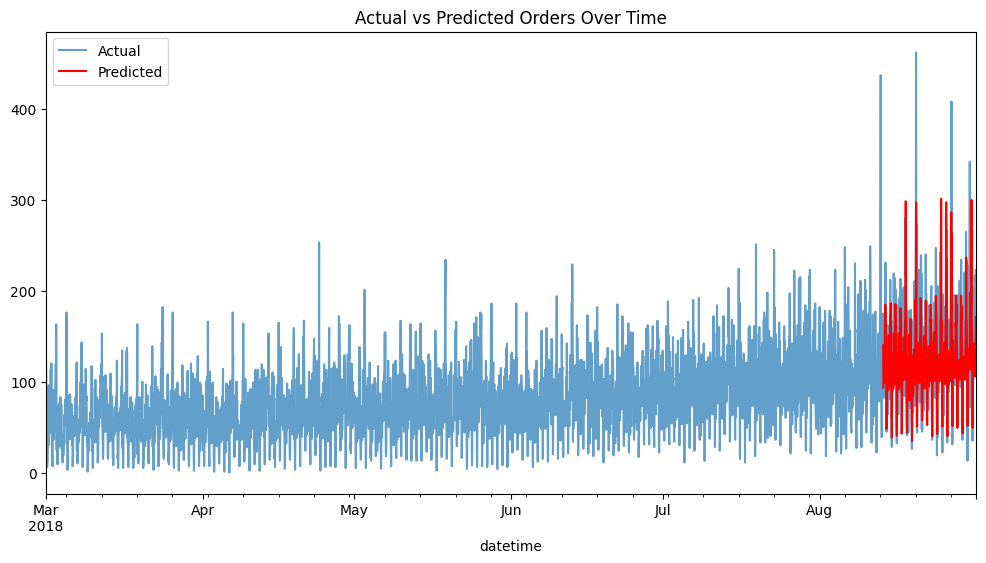

In [66]:


# make predictions
predictions = best_rf.predict(test_features)

# Create a copy of your dataframe for visualization
df_viz = df_1h.copy()

# Add predictions only to the test portion
df_viz['predicted_orders'] = np.nan
df_viz.loc[test.index, 'predicted_orders'] = predictions

# rename the original column
df_viz.rename(columns={'num_orders': 'actual_orders'}, inplace=True)

# Plot both actual and predicted
plt.figure(figsize=(12, 6))
df_viz['actual_orders'].plot(label='Actual', alpha=0.7)
df_viz['predicted_orders'].plot(label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted Orders Over Time')
plt.show()

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

🔎 The time-series plot comparing **actual vs. predicted orders** shows that the Random Forest model follows the real trend quite closely during the test period. The red line (predicted values) mirrors the main fluctuations of the blue line (actual values), especially capturing short-term changes.  
There are still a few moments where the predictions underestimate sharp peaks, but overall, the model tracks the real dynamics effectively.

</div>


# 🧾 **5. Conclusions**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

<br>

🔎 Throughout this project, we developed and compared several regression models to predict the **number of taxi orders** for the next hour, using <b>Sweet Lift Taxi’s historical data</b>.  
Our main objective was to find a model capable of achieving an **RMSE below 48** on the test set.

---

### ⚙️ **Model Performance Summary**

Lower RMSE values indicate higher predictive accuracy.  
All models were trained and tested under consistent conditions.

| **Model**                  | **RMSE**    | **Performance Notes** |
|-----------------------------|-------------|------------------------|
| Moving Average              | **84.68**   | Weak performance — unable to capture data dynamics effectively. |
| Autoregressive (AR)         | **69.92**   | Slightly better, but still high error and limited predictive power. |
| ARIMA (non-seasonal)        | **62.77**   | Moderate accuracy — it could likely perform better with seasonal settings, but those couldn’t be tested due to environment limitations.  |
| Linear Regression           | **52.28**   | Noticeable improvement — approaching the target threshold (<48). |
| 🌳 Random Forest            | **44.69**   | Strongest performer — successfully met the target and captured complex patterns in the data. |

---

### 🥇 **Best Performing Model**

✅ **🌳 Random Forest** achieved the lowest RMSE (**44.69**), outperforming all other models and surpassing the project’s goal.  
Its ensemble structure allowed it to model non-linear relationships and fluctuations in demand more effectively than traditional approaches.

---

### 💡 **Final Insight**

Overall, the Random Forest model demonstrates that **ensemble methods** can deliver robust and accurate forecasts in time-series problems where simpler statistical models fall short.  
</div>